In [3]:
%matplotlib inline

import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo


/home/meso/anaconda2/lib/python2.7/site-packages/SHARPpy-1.3.0-py2.7.egg/sharppy/sharptab/winds.py:14: UserWarning: Future versions of the routines in the winds module may include options to use height values instead of pressure to specify layers (i.e. SRH, wind shear, etc.)
  warnings.warn("Future versions of the routines in the winds module may include options to use height values instead of pressure to specify layers (i.e. SRH, wind shear, etc.)")


In [4]:
def load_oax(spc_file,skip):
    
    import numpy as np
    from StringIO import StringIO
    
    ## read in the file
    data = np.array([l.strip() for l in spc_file.split('\n')])

    ## necessary index points
    title_idx = np.where( data == '%TITLE%')[0][0]
    start_idx = np.where( data == '%RAW%' )[0] + 1
    finish_idx = np.where( data == '%END%')[0]

    ## create the plot title
    data_header = data[title_idx + 1].split()
    location = data_header[0]
    time = data_header[1][:11]

    ## put it all together for StringIO
    full_data = '\n'.join(data[start_idx : finish_idx][:])
    sound_data = StringIO( full_data )

    ## read the data into arrays
    pres, hght, tmpc, dwpc, wdir, wspd = np.genfromtxt( sound_data, delimiter=',', comments="%", unpack=True )
    
    prof = profile.create_profile(profile='default', pres=pres[::skip], hght=hght[::skip], tmpc=tmpc[::skip], dwpc=dwpc[::skip], wspd=wspd[::skip], wdir=wdir[::skip], missing=-9999, strictQC=True)

    
    return prof

In [21]:
def plot_rhi(morning_ffn,afternn_ffn,gs,gs_ind,xlabel,ylabel,ylabel2,ax_color):

    # This serves as an intensive exercise of matplotlib's transforms
    # and custom projection API. This example produces a so-called
    # SkewT-logP diagram, which is a common plot in meteorology for
    # displaying vertical profiles of temperature. As far as matplotlib is
    # concerned, the complexity comes from having X and Y axes that are
    # not orthogonal. This is handled by including a skew component to the
    # basic Axes transforms. Additional complexity comes in handling the
    # fact that the upper and lower X-axes have different data ranges, which
    # necessitates a bunch of custom classes for ticks,spines, and the axis
    # to handle this.

    import matplotlib.pyplot as plt
    import numpy as np
    from StringIO import StringIO
    from matplotlib.axes import Axes
    import matplotlib.transforms as transforms
    import matplotlib.axis as maxis
    import matplotlib.spines as mspines
    import matplotlib.path as mpath
    from matplotlib.projections import register_projection
    import matplotlib.gridspec as gridspec

    # The sole purpose of this class is to look at the upper, lower, or total
    # interval as appropriate and see what parts of the tick to draw, if any.
    class SkewXTick(maxis.XTick):
        def draw(self, renderer):
            if not self.get_visible(): return
            renderer.open_group(self.__name__)

            lower_interval = self.axes.xaxis.lower_interval
            upper_interval = self.axes.xaxis.upper_interval

            if self.gridOn and transforms.interval_contains(
                    self.axes.xaxis.get_view_interval(), self.get_loc()):
                self.gridline.draw(renderer)

            if transforms.interval_contains(lower_interval, self.get_loc()):
                if self.tick1On:
                    self.tick1line.draw(renderer)
                if self.label1On:
                    self.label1.draw(renderer)

            if transforms.interval_contains(upper_interval, self.get_loc()):
                if self.tick2On:
                    self.tick2line.draw(renderer)
                if self.label2On:
                    self.label2.draw(renderer)

            renderer.close_group(self.__name__)


    # This class exists to provide two separate sets of intervals to the tick,
    # as well as create instances of the custom tick
    class SkewXAxis(maxis.XAxis):
        def __init__(self, *args, **kwargs):
            maxis.XAxis.__init__(self, *args, **kwargs)
            self.upper_interval = 0.0, 1.0

        def _get_tick(self, major):
            return SkewXTick(self.axes, 0, '', major=major)

        @property
        def lower_interval(self):
            return self.axes.viewLim.intervalx

        def get_view_interval(self):
            return self.upper_interval[0], self.axes.viewLim.intervalx[1]


    # This class exists to calculate the separate data range of the
    # upper X-axis and draw the spine there. It also provides this range
    # to the X-axis artist for ticking and gridlines
    class SkewSpine(mspines.Spine):
        def _adjust_location(self):
            trans = self.axes.transDataToAxes.inverted()
            if self.spine_type == 'top':
                yloc = 1.0
            else:
                yloc = 0.0
            left = trans.transform_point((0.0, yloc))[0]
            right = trans.transform_point((1.0, yloc))[0]

            pts  = self._path.vertices
            pts[0, 0] = left
            pts[1, 0] = right
            self.axis.upper_interval = (left, right)


    # This class handles registration of the skew-xaxes as a projection as well
    # as setting up the appropriate transformations. It also overrides standard
    # spines and axes instances as appropriate.
    class SkewXAxes(Axes):
        # The projection must specify a name.  This will be used be the
        # user to select the projection, i.e. ``subplot(111,
        # projection='skewx')``.
        name = 'skewx'

        def _init_axis(self):
            #Taken from Axes and modified to use our modified X-axis
            self.xaxis = SkewXAxis(self)
            self.spines['top'].register_axis(self.xaxis)
            self.spines['bottom'].register_axis(self.xaxis)
            self.yaxis = maxis.YAxis(self)
            self.spines['left'].register_axis(self.yaxis)
            self.spines['right'].register_axis(self.yaxis)

        def _gen_axes_spines(self):
            spines = {'top':SkewSpine.linear_spine(self, 'top'),
                      'bottom':mspines.Spine.linear_spine(self, 'bottom'),
                      'left':mspines.Spine.linear_spine(self, 'left'),
                      'right':mspines.Spine.linear_spine(self, 'right')}
            return spines

        def _set_lim_and_transforms(self):
            """
            This is called once when the plot is created to set up all the
            transforms for the data, text and grids.
            """
            rot = 25

            #Get the standard transform setup from the Axes base class
            Axes._set_lim_and_transforms(self)

            # Need to put the skew in the middle, after the scale and limits,
            # but before the transAxes. This way, the skew is done in Axes
            # coordinates thus performing the transform around the proper origin
            # We keep the pre-transAxes transform around for other users, like the
            # spines for finding bounds
            self.transDataToAxes = self.transScale + (self.transLimits +
                    transforms.Affine2D().skew_deg(rot, 0))

            # Create the full transform from Data to Pixels
            self.transData = self.transDataToAxes + self.transAxes

            # Blended transforms like this need to have the skewing applied using
            # both axes, in axes coords like before.
            self._xaxis_transform = (transforms.blended_transform_factory(
                        self.transScale + self.transLimits,
                        transforms.IdentityTransform()) +
                    transforms.Affine2D().skew_deg(rot, 0)) + self.transAxes

    # Now register the projection with matplotlib so the user can select
    # it.
    register_projection(SkewXAxes)
    # create nexted gridspec
    gs_nest = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = gs[gs_ind], width_ratios=[7,1], wspace = 0)
    print gs_ind
    ax1 = plt.subplot(gs_nest[0], projection='skewx')
    ax1.grid(b=True, which='major', color='#cfa751', linestyle='-',alpha=0.5)

    pmax = 1020
    pmin = 100
    dp = -10
    presvals = np.arange(int(pmax), int(pmin)+dp, dp)

    #load data
    skip = 2
    morning_prof = load_oax(morning_ffn,skip)
    skip = 1
    afternn_prof = load_oax(afternn_ffn,skip)


    # plot the moist-adiabats
    for t in np.arange(5,35,5):
        tw = []
        for p in presvals:
            tw.append(thermo.wetlift(1000., t, p))
        ax1.semilogy(tw,presvals,color='#1ba583',linestyle=':')

    def thetas(theta, presvals):
        return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

    # plot the dry adiabats
    for t in np.arange(-50,110,10):
        ax1.semilogy(thetas(t, presvals),presvals,color='#1ba583',linestyle=':')

    # plt.title(' OAX 140616/1900 (Observed)', fontsize=14, loc='left')
    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dicatated by the typical meteorological plot
    ax1.semilogy(morning_prof.tmpc, morning_prof.pres-10, 'k-', lw=1.5) #calibration offset errors
    ax1.semilogy(morning_prof.dwpc-2.3, morning_prof.pres-10, '-', lw=1.5,color='0.5') #calibration offset errors
    ax1.semilogy(afternn_prof.tmpc, afternn_prof.pres, 'k-', lw=3)
    ax1.semilogy(afternn_prof.dwpc, afternn_prof.pres, '-', lw=3,color='0.5')
    
    # Disables the log-formatting that comes with semilogy
    ax1.yaxis.set_major_formatter(plt.ScalarFormatter())
    
    #primary axis limts and font size
    ax1.xaxis.set_major_locator(plt.MultipleLocator(10))
    ax1.set_yticks(np.linspace(600,1000,5))
    ax1.set_xlim(0,30)
    ax1.set_ylim(1020,600)
    ax1.set_xlabel(xlabel,size=16) 
    ax1.set_ylabel(ylabel,size=16)
    ax1.set_axis_bgcolor(ax_color)
    
    #secondary y axis for height
    ax2 = ax1.twinx()
    ax2.set_yticks(())
    ax2.set_ylim(0,4.388)
    
    #set font sizes
    for item in (ax1.get_xticklabels() + ax1.get_yticklabels()):# + ax2.get_yticklabels()):
        item.set_fontsize(14)
    
    #setup wind barb axis
    ax3 = plt.subplot(gs_nest[1])
    ax3.yaxis.tick_right()
    ax3.set_yticks((0,1,2,3,4))
    ax3.set_ylim(0,4.388)
    ax3.set_ylabel(ylabel2,size=16)
    ax3.yaxis.set_label_position("right")
    ax3.spines["top"].set_visible(False)
    ax3.spines["bottom"].set_visible(False)
    #ax3.spines["left"].set_visible(False)
    #ax3.spines["right"].set_visible(False)
    ax3.set_xlim(-1,1)
    ax3.set_xticks(())
    ax3.patch.set_visible(False)
    
    #plot wind barbs
    morning_u,morning_v = utils.vec2comp(morning_prof.wdir[::14],morning_prof.wspd[::14]*2) #double to use 2.5/5m/s barbs
    morning_h           = morning_prof.hght[::14]
    
    morning_u           = np.ma.masked_where(morning_h>4000,morning_u)
    morning_v           = np.ma.masked_where(morning_h>4000,morning_v)
    morning_h           = np.ma.masked_where(morning_h>4000,morning_h)
    
    monring_x           = -np.ones((len(morning_h),1))
    
    
    
    afternn_u,afternn_v = utils.vec2comp(afternn_prof.wdir[::10],afternn_prof.wspd[::10]*2) #double to use 2.5/5m/s barbs
    afternn_h           = afternn_prof.hght[::10]
    
    afternn_u           = np.ma.masked_where(afternn_h>4000,afternn_u)
    afternn_v           = np.ma.masked_where(afternn_h>4000,afternn_v)
    afternn_h           = np.ma.masked_where(afternn_h>4000,afternn_h)
    
    afternn_x           = np.ones((len(afternn_h),1))
    
    ax3.barbs(monring_x,morning_h/1000,morning_u,morning_v, clip_on=False, length=8, lw=1)
    ax3.barbs(afternn_x,afternn_h/1000,afternn_u,afternn_v, clip_on=False, length=8, lw=1)
    #axline(afternn_x,afternn_h,'k-',lw=1)

    #filter winds to required height
    #enable plotting outside of axis
    

0


/home/meso/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


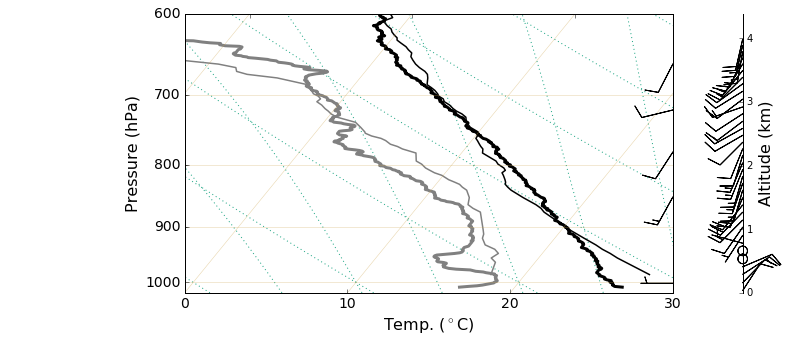

In [22]:
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec

fig       = plt.figure(figsize=(10, 5))
gs        = gridspec.GridSpec(1,1) #seperate skew t and wind

null_color = '#ffffff'
weak_color = '#ffffcc'
sts_color  = '#ffcccc'

ybbn_path = '/run/media/meso/DATA/phd/obs/profile/sounding/sb-ts-ybbn-oax/'
rs92_path = '/run/media/meso/DATA/phd/obs/profile/sounding/field/oax/'

ybbn_04Z_fid = open(ybbn_path+'201411270400_040842.oax', 'r').read()
rs92_02Z_fid = open(rs92_path+'201411270154_kalbar_02Z.oax', 'r').read()
plot_rhi(rs92_02Z_fid,ybbn_04Z_fid,gs,0,'Temp. ($^\circ$C)','Pressure (hPa)','Altitude (km)',null_color)

plt.savefig('tmp/20141127_rs92_ybbn.png', dpi=300)
plt.show()
